# **Vibration of Bearing Defect Classification using CNN**

## **Step 0 - Setting**
Import TensorFlow and Other Support Library

In [ ]:
import tensorflow as tf
print("TensorFlow Version", tf.__version__)

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import random
from os.path import isfile, join
from pathlib import Path
from matplotlib.pyplot import imread, close
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
from tensorflow.keras import regularizers

TensorFlow Version 2.17.0


Mounting Google Drive


In [ ]:
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

## **Step 1 - Preparing Dataset**
Create function to read your data

In [ ]:
def read_file(source):
    file_paths = []
    for root, dirs, files in os.walk(source, topdown=False):
        for file_name in sorted(files):
            path = os.path.join(root, file_name)
            file_paths.append(path)
    return file_paths

In [ ]:
read_file('/content/drive/MyDrive/Tugas Akhir/Thesis Dataset')

['/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img1.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img10.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img11.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img12.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img13.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img14.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img15.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img16.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img17.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img18.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img19.png',
 '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img2.png',
 '/content/drive/M

In [ ]:
def read_csv(source, label: str):

  df = pd.read_csv(source, sep = ';')
  df.drop(df.index[:3], inplace=True)
  df.drop(columns='Timestamp', inplace=True)
  df.reset_index(drop=True, inplace=True)
  df = df.iloc[:512000]
  df.columns = ['Data']
  df['Data'] = df['Data'].replace(',', '.', regex=True)
  df['Data'] = df['Data'].astype(np.float32)
  fault = np.full((len(df['Data'])), label)
  df['Status'] = fault
  return df

In [ ]:
def load_data(source):
    df = []
    file_paths = read_file(source)

    conditions = ['Normal', 'Inner', 'Outer', 'Ball']

    for file_path in file_paths:
        folder, filename = os.path.split(file_path)
        if '3000 RPM' in folder:
            rpm = '3000 RPM'
        elif '4000 RPM' in folder:
            rpm = '4000 RPM'
        else:
            continue

        # Checking the file is valid and match with filename
        if any(name in filename for name in conditions) and os.path.isfile(file_path):
            for condition in conditions:
                if condition in filename:
                    # File is valid, read the data
                    data = read_csv(file_path, condition)
                    if not data.empty:
                        print(f'Processing file: {file_path}')
                        print(f'Condition: {condition}, RPM : {rpm}')
                        print(data['Status'].unique())
                        count = len(data)
                        print(f'Jumlah data: {count}')
                        df.append(data)
    return df


In [ ]:
data = load_data('/content/drive/MyDrive/Tugas Akhir/Thesis Dataset')

Processing file: /content/drive/MyDrive/Tugas Akhir/Thesis Dataset/3000 RPM/Ball 1.csv
Condition: Ball, RPM : 3000 RPM
['Ball']
Jumlah data: 512000
Processing file: /content/drive/MyDrive/Tugas Akhir/Thesis Dataset/3000 RPM/Ball 2.csv
Condition: Ball, RPM : 3000 RPM
['Ball']
Jumlah data: 512000
Processing file: /content/drive/MyDrive/Tugas Akhir/Thesis Dataset/3000 RPM/Ball 3.csv
Condition: Ball, RPM : 3000 RPM
['Ball']
Jumlah data: 512000
Processing file: /content/drive/MyDrive/Tugas Akhir/Thesis Dataset/3000 RPM/Inner 1.csv
Condition: Inner, RPM : 3000 RPM
['Inner']
Jumlah data: 512000
Processing file: /content/drive/MyDrive/Tugas Akhir/Thesis Dataset/3000 RPM/Inner 2.csv
Condition: Inner, RPM : 3000 RPM
['Inner']
Jumlah data: 512000
Processing file: /content/drive/MyDrive/Tugas Akhir/Thesis Dataset/3000 RPM/Inner 3.csv
Condition: Inner, RPM : 3000 RPM
['Inner']
Jumlah data: 512000
Processing file: /content/drive/MyDrive/Tugas Akhir/Thesis Dataset/3000 RPM/Normal 1.csv
Condition: Nor

In [ ]:
len(data)

24

In [ ]:
normal_1  = data[6]
normal_2  = data[18]
ball_1    = data[1]
ball_2    = data[12]
inner_1   = data[3]
inner_2   = data[15]
outer_1   = data[9]
outer_2   = data[21]

## **Step 2 - Visualization**
Visualize Data into a Time and Frequencies Domain Graph

### **Fast Fourier Transform**



In [ ]:
def create_spectrum(data):
    # Panjang data
    n = len(data['Data'])
    Fs = 25600
    # Menghitung FFT
    fft = np.fft.fft(data['Data'])

    # Menghitung frekuensi menggunakan fftfreq
    freq = np.fft.fftfreq(n, d=1/Fs)

    # Menghitung Amplitudo dan mengkonversi ke dB
    amplitude = np.abs(fft) / n
    amplitude_db = 20 * np.log10(amplitude)

    # Mengambil hanya frekuensi positif
    L = np.arange(1, n // 2, dtype="int")
    return amplitude_db[L], freq[L]

### **Plotting Time and Frequency Domain Graph**

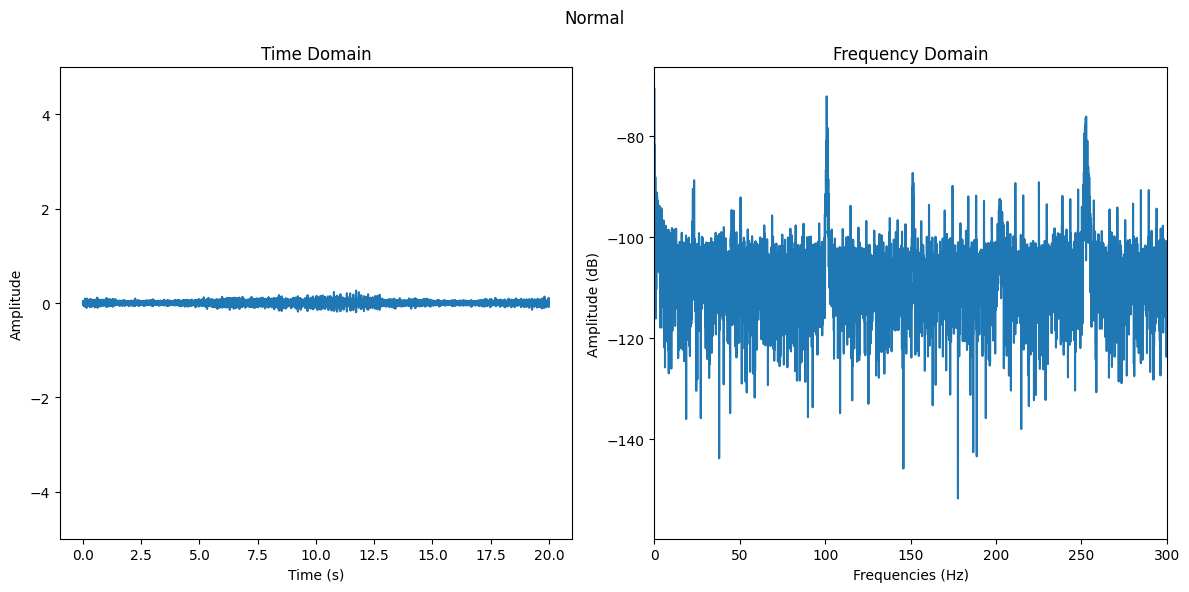

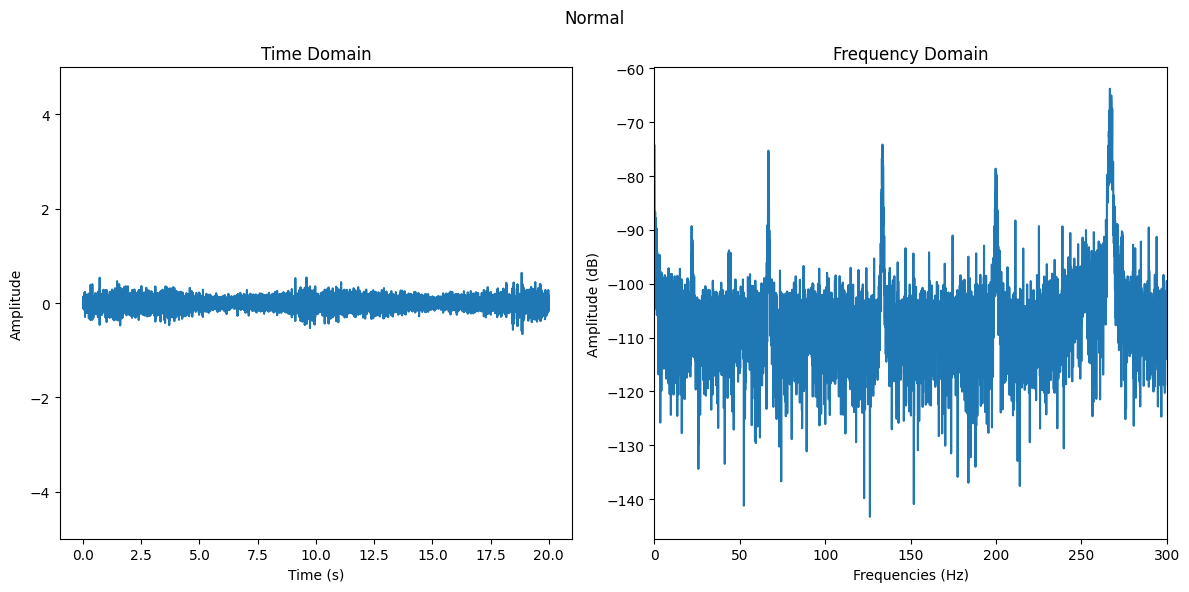

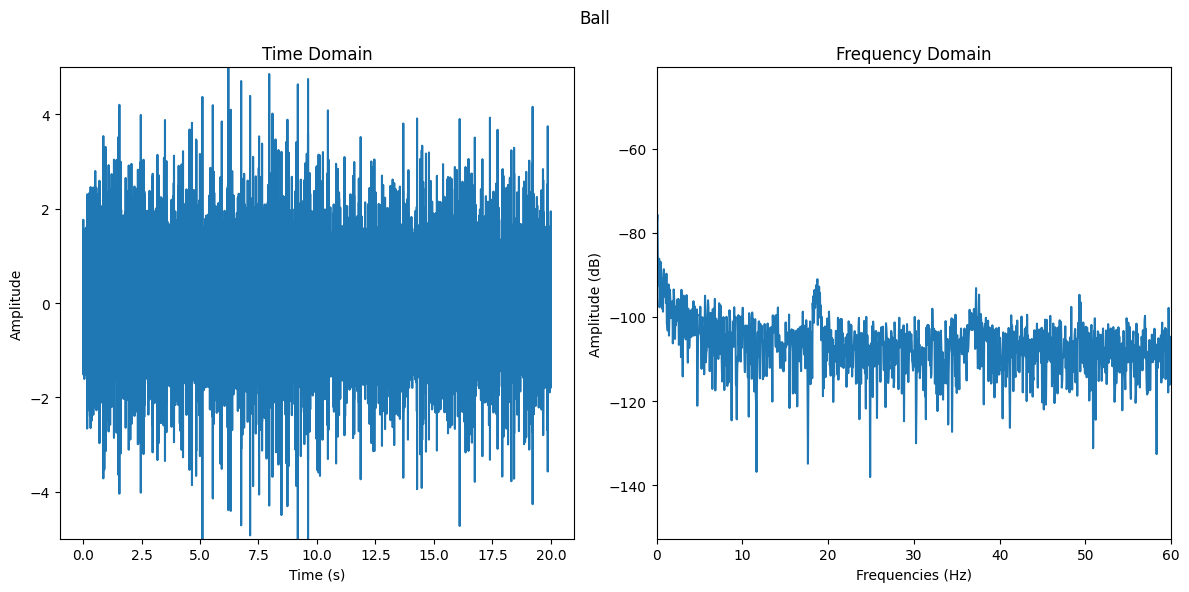

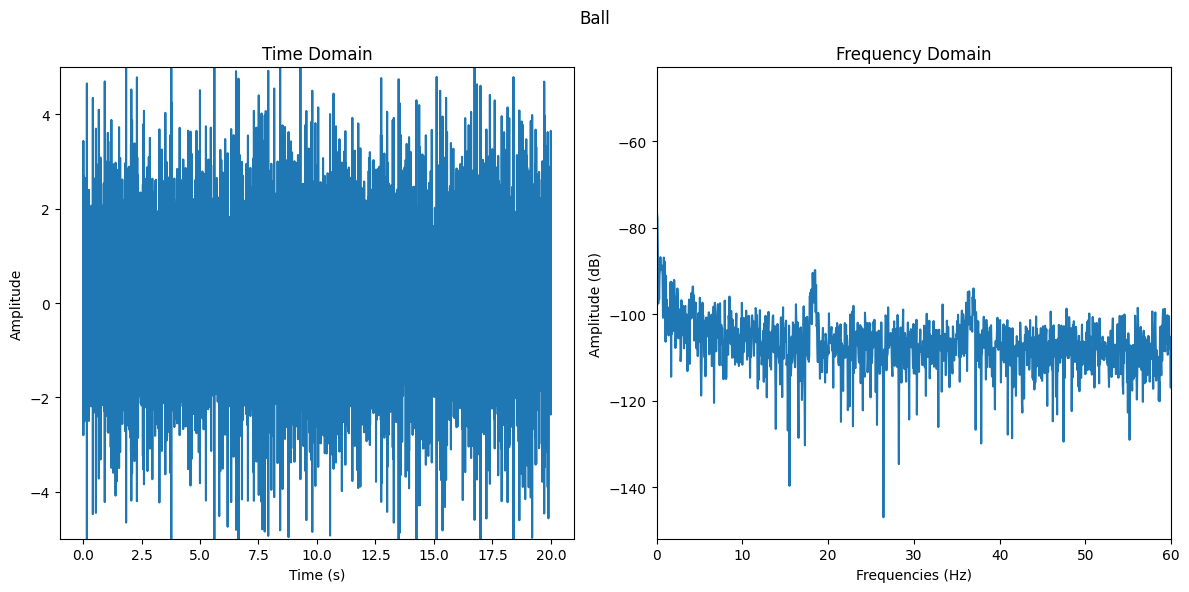

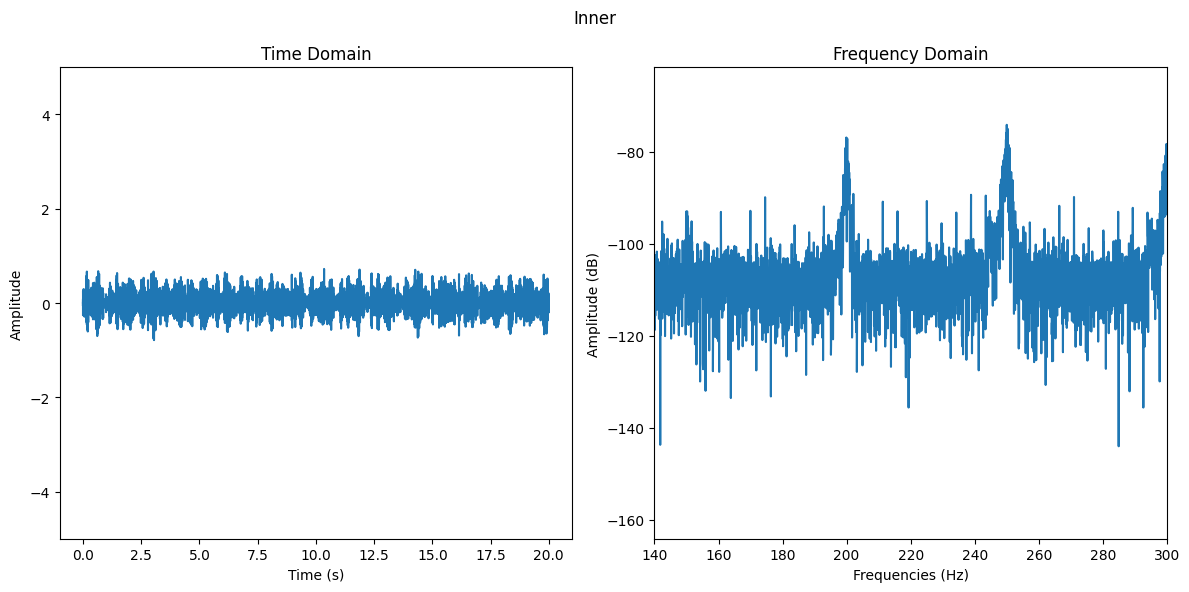

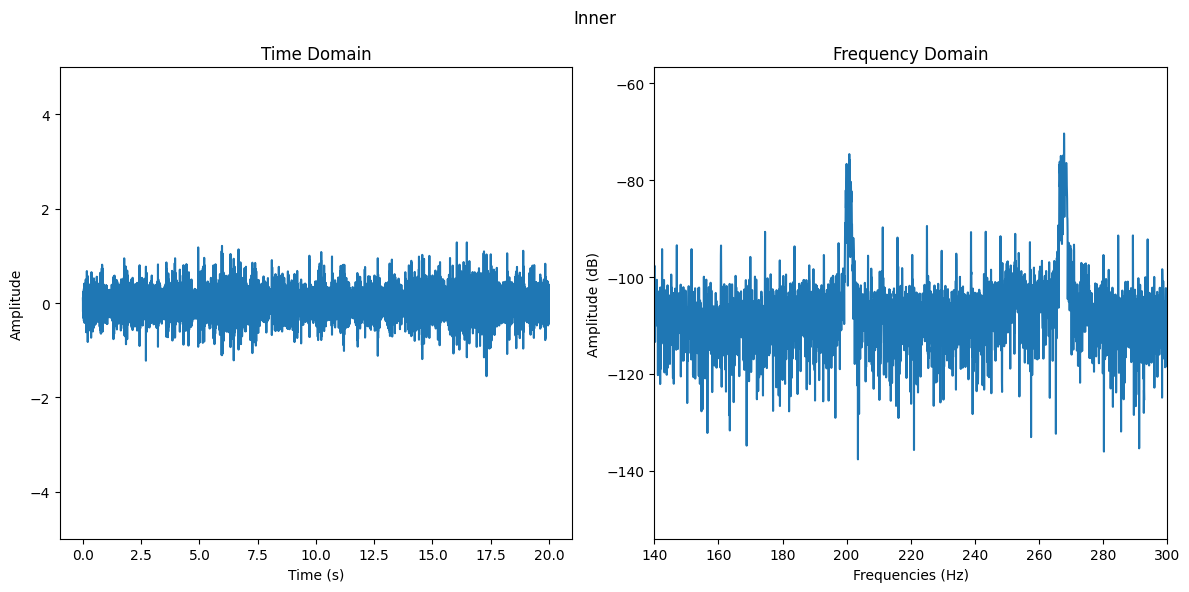

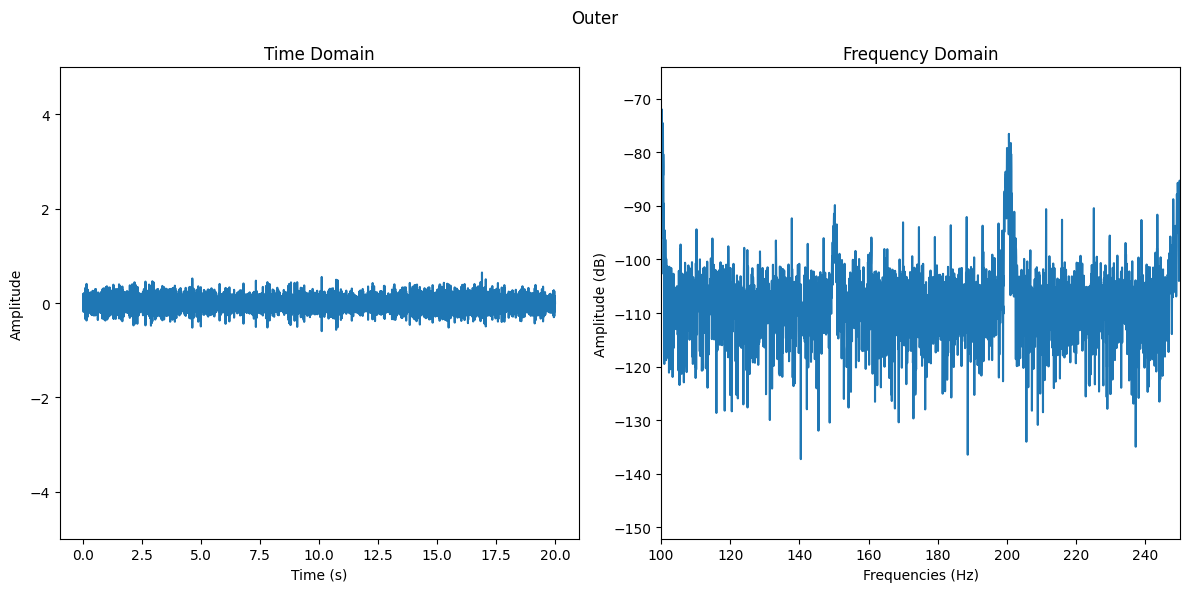

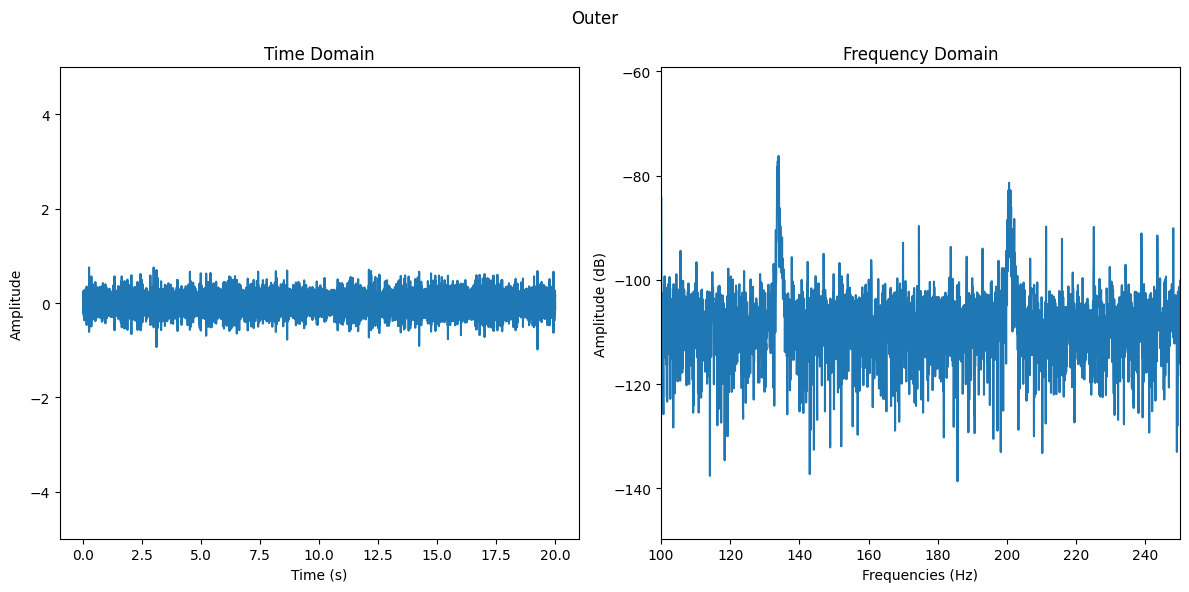

In [ ]:
%matplotlib inline

data_dict = {
    'Normal' : [normal_1, normal_2],
    'Ball' : [ball_1, ball_2],
    'Inner' : [inner_1, inner_2],
    'Outer' : [outer_1, outer_2],
    }
Fs = 25600

for name, dfs in data_dict.items():
  for df in dfs:
    time = np.arange(len(df)) / Fs
    amplitude_db, freq = create_spectrum(df)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle(name)
    axs[0].plot(time, df['Data'],)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_ylim(-5, 5)
    axs[0].set_title('Time Domain')

    axs[1].plot(freq, amplitude_db)
    axs[1].set_ylabel('Amplitude (dB)')
    axs[1].set_xlabel('Frequencies (Hz)')
    axs[1].set_title('Frequency Domain')
    if 'Inner' in name:
      axs[1].set_xlim(140, 300)
    elif 'Outer' in name:
      axs[1].set_xlim(100, 250)
    elif 'Ball' in name:
      axs[1].set_xlim(0, 60)
    else:
      axs[1].set_xlim(0, 300)

    plt.tight_layout()
    plt.show()

## **Step 3 - Preprocessing**

### **Data Segmentation**
Vibration data are split into several segment

In [ ]:
def split_signal(data, split_by_sec):
    L = len(data)          # length of the signal
    num_5s_splits = L // split_by_sec
    last = num_5s_splits * split_by_sec
    x_new = data[:last]
    x_new = np.array_split(x_new, split_by_sec)
    x_new = np.array(x_new)
    return x_new

### **Spectrogram**
A spectrogram shows the frequency spectrum of a signal as it changes over time, with color denoting amplitude.

In [ ]:
def spectrogram(data, label: str):
    stft = librosa.stft(data, n_fft=20480, hop_length=256)
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    img = librosa.display.specshow(S_db, sr=Fs, x_axis='time', y_axis='linear', cmap='viridis')
    return img

input data shape (25600, 20)
After reshape input data shape (20, 25600)


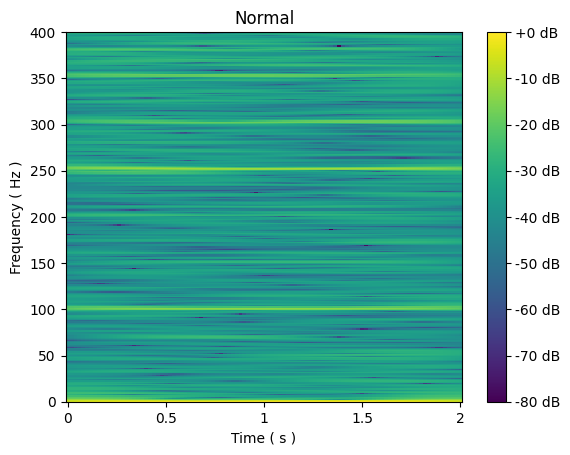

input data shape (25600, 20)
After reshape input data shape (20, 25600)


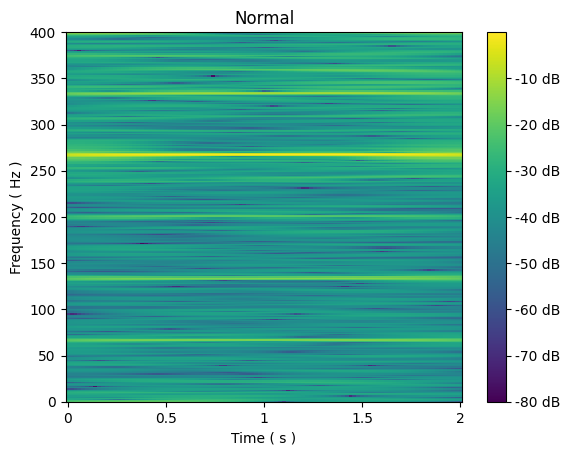

input data shape (25600, 20)
After reshape input data shape (20, 25600)


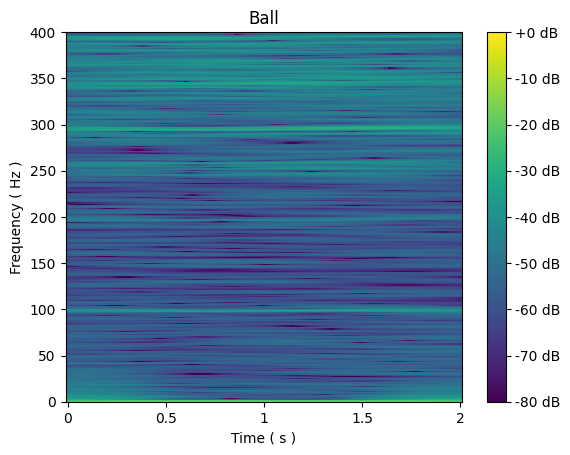

input data shape (25600, 20)
After reshape input data shape (20, 25600)


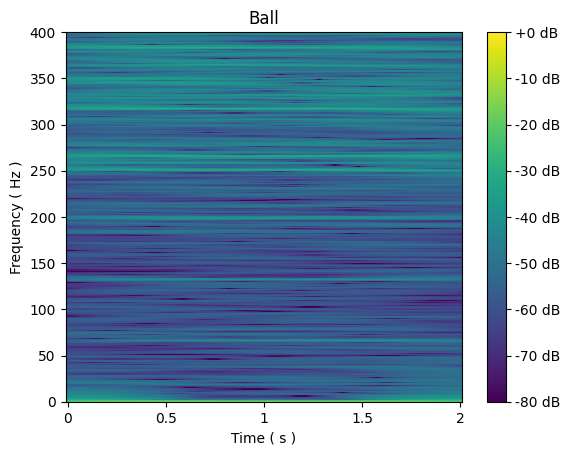

input data shape (25600, 20)
After reshape input data shape (20, 25600)


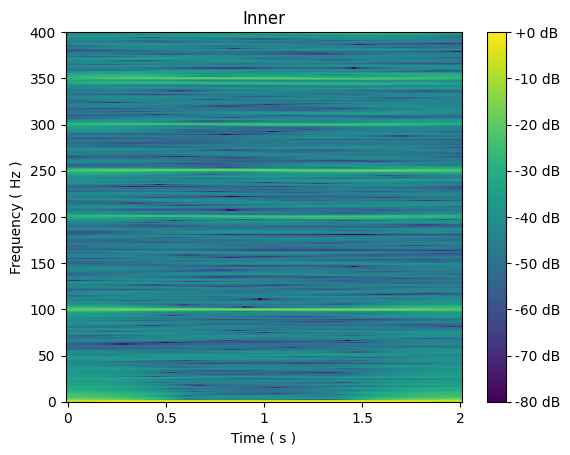

input data shape (25600, 20)
After reshape input data shape (20, 25600)


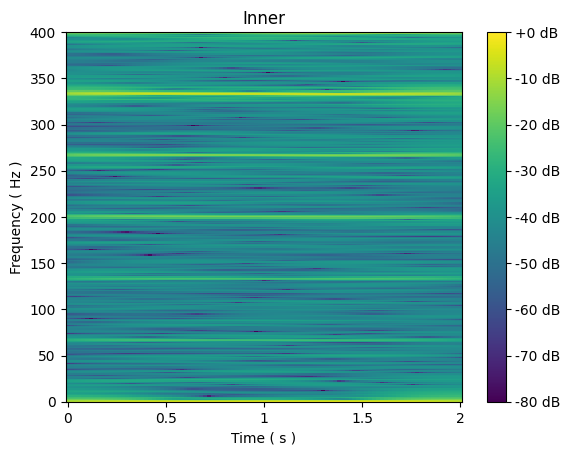

input data shape (25600, 20)
After reshape input data shape (20, 25600)


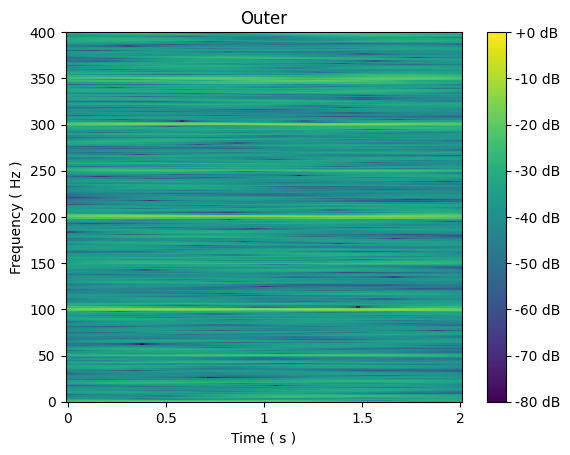

input data shape (25600, 20)
After reshape input data shape (20, 25600)


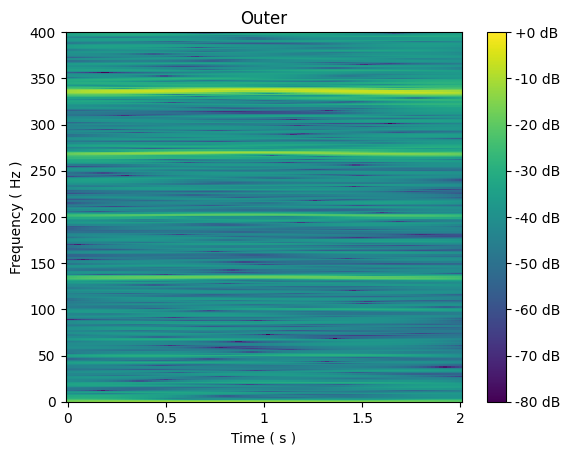

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

data_dict = {
    'Normal' : [normal_1, normal_2],
    'Ball' : [ball_1, ball_2],
    'Inner' : [inner_1, inner_2],
    'Outer' : [outer_1, outer_2],
    }

for condition, dfs in data_dict.items():
    for df in dfs:
        signal = split_signal(df['Data'], Fs)
        print(f'input data shape', signal.shape)
        signal = np.reshape(signal, (signal.shape[1], signal.shape[0]))
        print(f"After reshape input data shape", signal.shape)

        sample = np.array(signal.shape[0])
        for l in range(sample):
            spec_img = spectrogram(signal[l], condition)
            plt.ylim(0, 400)
            # Plot spectrogram
            if l == 0:
              plt.title(condition)
              plt.colorbar(spec_img, format="%+2.f dB", cmap='viridis')
              plt.ylabel('Frequency ( Hz )')
              plt.xlabel('Time ( s )')
              plt.show()
            else:
              plt.close()

### **Generate and Save Spectrogram Image**
Create directory to save spectrogram image based on fault class

In [ ]:
def create_spectrogram(data, label: str, index):
    database = '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset'
    if not os.path.exists(f'{database}/data/{label}'):
        os.makedirs(f'{database}/data/{label}')

    signal1 = np.reshape(data, (data.shape[1], data.shape[0]))
    print(f"After reshape input data shape", signal1.shape)

    sample = np.array(signal1.shape[0])
    for l in range(sample):
        spec_img = spectrogram(signal1[l], label)
        plt.ylim(0, 400)
        plt.savefig(f'{database}/data/{label}/spec_img_{index}_{l+1}.png')
        plt.close()

In [ ]:
data_dict = {
    'Normal': [data[6], data[7], data[8], data[18], data[19], data[20]],
    'Ball': [data[0], data[1], data[2], data[12], data[13], data[14]],
    'Inner': [data[3], data[4], data[5], data[15], data[16], data[17]],
    'Outer': [data[9], data[10], data[11], data[21], data[22], data[23]],
}

for condition, dfs in data_dict.items():
    for idx, df in enumerate(dfs):
        signal1 = split_signal(df['Data'], Fs)
        print(f'input data shape', signal1.shape)
        spec_img = create_spectrogram(signal1, condition, idx)

input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20, 25600)
input data shape (25600, 20)
After reshape input data shape (20,

## **Step 4 - Training Dataset with CNN Classifier**

### **Data Augmentation**

Create a kind of data train to be more varied

In [ ]:
data_dir = '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/data'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 10,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   fill_mode = 'nearest',
                                   validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

img_size = (200, 200)

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=img_size,
                                                    class_mode='categorical',
                                                    subset='training')

test_generator = test_datagen.flow_from_directory(data_dir,
                                                  target_size=img_size,
                                                  class_mode='categorical',
                                                  subset='validation')

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


### **Create, Compile and Train the Model**

In [ ]:
model = Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 135424)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 135424)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      17,334,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,705,732 (67.54 MB)

 Trainable params: 17,705,732 (67.54 MB)

 Non-trainable params: 0 (0.00 B)

### **Callback**
Callback allows to stop the training process when the desired accuracy is reached or validation loss in stagnant or decrease

In [ ]:
class CustomCallback(Callback):
      def on_epoch_end(self, epoch, logs={}):
          if (logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99):
              print('\nAccuracy Above 99% -- Stopping Training')
              self.model.stop_training=True

### **Fitting the Model**

In [ ]:
history = model.fit(train_generator,
                    batch_size = 32,
                    epochs = 50,
                    verbose = 1,
                    callbacks=[CustomCallback()],
                    validation_data = test_generator)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 161s 10s/step - accuracy: 0.2420 - loss: 2.0366 - val_accuracy: 0.6562 - val_loss: 1.2892
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 149s 8s/step - accuracy: 0.4206 - loss: 1.2585 - val_accuracy: 0.5000 - val_loss: 0.9036
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 148s 9s/step - accuracy: 0.5737 - loss: 0.8785 - val_accuracy: 0.7708 - val_loss: 0.5819
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - accuracy: 0.7591 - loss: 0.5922 - val_accuracy: 0.9062 - val_loss: 0.3469
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - accuracy: 0.8383 - loss: 0.4570 - val_accuracy: 0.9167 - val_loss: 0.2439
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - accuracy: 0.8456 - loss: 0.3675 - val_accuracy: 0.9062 - val_loss: 0.2110
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 108s 8s/step - accuracy: 0.8495 - loss: 0.3430 - val_accuracy: 0.9479 - val_loss: 0.1953
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.8974 - loss: 0.2632 - val_accuracy: 0.9271 - val_loss: 0

In [ ]:
acc = model.evaluate(test_generator, verbose=0)
print('Test accuracy:', acc[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='lower right')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

## **Step 5 - Prediction**
Use a Random Spectrogram to Determine Fault Classification

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


input data shape (25600, 20)
After reshape input data shape (20, 25600)


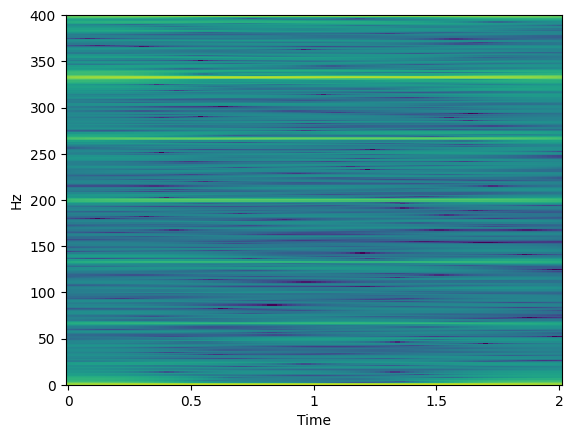

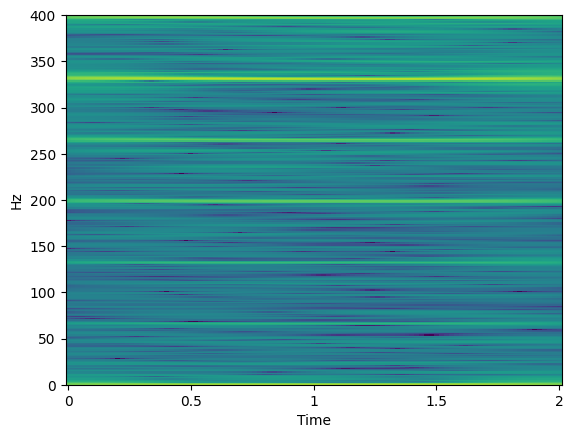

In [ ]:
if not os.path.exists(f'/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data'):
  os.makedirs(f'/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data')

data_pred = read_csv('/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/Inner 4.csv', 'Unknown')

Fs = 25600

signal_pred = split_signal(data_pred['Data'], Fs)
print(f'input data shape', signal_pred.shape)
signal_pred = np.reshape(signal_pred, (signal_pred.shape[1], signal_pred.shape[0]))
print(f"After reshape input data shape", signal_pred.shape)

sample = np.array(signal_pred.shape[0])
for l in range(sample):
    spec_img = spectrogram(signal_pred[l], 'Unknown')
    plt.ylim(0,400)
    plt.savefig(f'/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/spec_img{l+1}.png')
    if l == 0:
      plt.show()
      plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Hasil Prediksi :  [0. 1. 0. 0.] 

Fault Type :  Inner
Confidence :  0.47536692


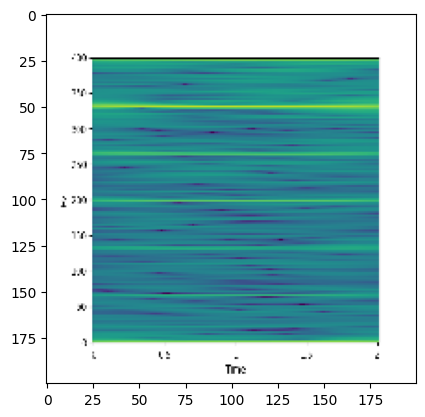

In [ ]:
folder_path = '/content/drive/MyDrive/Tugas Akhir/Thesis Dataset/Unknown/data/'

random_spec = random.choice(os.listdir(folder_path))
path = os.path.join(folder_path, random_spec)

img = tf.keras.utils.load_img(path, target_size=(200, 200))
imgplot = plt.imshow(img)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print('Hasil Prediksi : ', classes[0], '\n')

probabilities = tf.nn.softmax(classes[0]).numpy()
predicted_class = np.argmax(classes[0])
class_names = ['Ball', 'Inner', 'Normal', 'Outer']

print('Fault Type : ', class_names[predicted_class])
print('Confidence : ', probabilities[predicted_class])

In [ ]:
model.save('/content/drive/MyDrive/Tugas Akhir')